# Introduction

This project focuses on imbalanced dataset and understanding the importance of performance metrics. Also, using real-time knowledge for better data pre-processing, understanding the distribution attributes using various visualization tools and using Gausian Mixture Model(GMM) in processing bimodal data distribution. In addition, two models of Random Forest Classifiers are used for predicting stroke.

# Importing libraries

In [313]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Data Analysis

In [314]:
df = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


To predict the stroke, we have 3 continuous variables - *age, avg_glucose_level, bmi* and 7 categorical variables - *gender,hypertension, heart_disease, ever_married, Work_type, residence_type, smoking_status*. *id* is just a unique number without any value towards stroke prediction and can be dropped 

In [315]:
df.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


Based on the brief we can report two things.
1. *bmi* holds a few null values
2. *bmi* ranges from 10 to 97. [We know that, bmi <18.5 is underweight, 18.5 - 25 healthy, 25 - 30 overweight, >30 Obese, >40 morbidly obese (very rare and almost impossible)]. Hence, very high bmi values can be considered as noise/outliers.


In [316]:
df_no_mv = df.dropna(axis=0, how='any')
x_opt_bmi = df_no_mv[df_no_mv['bmi']<=45]

#dropping id
data = x_opt_bmi.drop(['id'], axis =1).reset_index(drop=True)

In [317]:
def plot_stroke_count(y_count):
    ax = sns.countplot(x=y_count, label = 'stroke count')
    N , Y = y_count.value_counts()
    print('Number of people without stroke attack - ', N)
    print('Number of people with stroke attack - ', Y)

Number of people without stroke attack -  4552
Number of people with stroke attack -  202


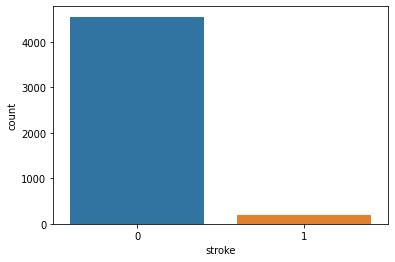

In [318]:
y = data.stroke
x = data.drop(['stroke'], axis=1)
plot_stroke_count(y)

The stroke to no-stroke-attack ratio is 1:20, indicating that the dataset is highly imbalanced. 

# Random Forest Classification with Univariate Feature Selection

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [320]:
def kBest_model(x_pp, y, kv):
    x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(x_pp, y, test_size=0.3, random_state=42)
    select_feature = SelectKBest(chi2, k=kv).fit(x_train_k, y_train_k)
    rec_result = pd.DataFrame({'features':x_train_k.columns,'score':select_feature.scores_}).sort_values(
        by=['score'], ascending=False)
    x_train_rfc = select_feature.transform(x_train_k)
    x_test_rfc = select_feature.transform(x_test_k)
    clf_rf = RandomForestClassifier()      
    clr_rf = clf_rf.fit(x_train_rfc,y_train_k)
    y_pred_k = clf_rf.predict(x_test_rfc)
    ac = accuracy_score(y_test_k,y_pred_k)
    print('Accuracy is: ',ac)
    cm = confusion_matrix(y_test_k,y_pred_k)
    sns.heatmap(cm,annot=True,fmt="d")
    return y_test_k,y_pred_k
    

In [321]:
#Encoding categarical variables
from sklearn.preprocessing import LabelEncoder

data_rfe = pd.DataFrame(x)
labelEncoder = LabelEncoder()
data_rfe['gender'] = labelEncoder.fit_transform(data_rfe['gender'])
data_rfe["ever_married"] = labelEncoder.fit_transform(data_rfe['ever_married'])
data_rfe['work_type'] = labelEncoder.fit_transform(data_rfe['work_type'])
data_rfe['Residence_type'] = labelEncoder.fit_transform(data_rfe['Residence_type'])
data_rfe['smoking_status'] = labelEncoder.fit_transform(data_rfe['smoking_status'])
data_rfe['heart_disease'] = labelEncoder.fit_transform(data_rfe['heart_disease'])

Accuracy is:  0.9502452697967765


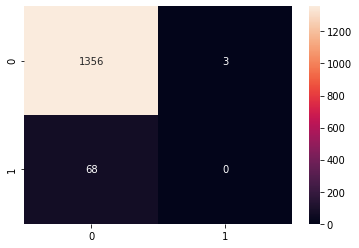

In [322]:
y_test_rfe,y_pred_rfe = kBest_model(data_rfe, y, 6)


Based on accuracy, the model is making a correct prediction 95% of the time, indicating that the model is doing a great job.

However, the confusion matrix reveals that stroke was correctly predicted ZERO times, unlike its couterpart. The model has just predicted no-stroke in almost all cases.

In [323]:
print(classification_report(y_test_rfe,y_pred_rfe))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1359
           1       0.00      0.00      0.00        68

    accuracy                           0.95      1427
   macro avg       0.48      0.50      0.49      1427
weighted avg       0.91      0.95      0.93      1427



We get recall = 0.01, which means that the model is broken and it can not correctly classify even a single entry when the actual value is positive. 

Further, precision also expresses an irregularity in the proportion of the data points in our model

**Thus, accuracy alone doesn't tell the full story**

# AUC and ROC

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [324]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [325]:
def roc_auc_model(y_test_rfe,y_pred_rfe):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_rfe,y_pred_rfe)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

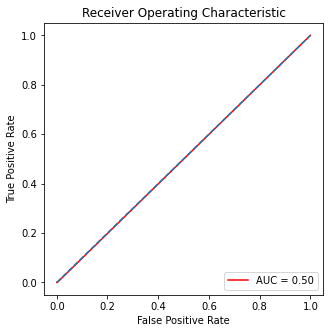

In [326]:
roc_auc_model(y_test_rfe,y_pred_rfe)

Further, AUC 0.5 indicates that the classifier is not able to distinguish between Positive and Negative class points. Either the classifier is predicting random class or constant class for all the data points

Most ML algorithms used for classification are designed around the assumption of an equal number of examples in each class. 

Appropriate sampling is one of the techniques to handle imbalanced datasets

# SAMPLING

# Random Under-Sampling

Reducing the size of data so as to increase the ratio between minority and majority classes

In [327]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_us, y_us = undersample.fit_resample(data_rfe, y)

Number of people without stroke attack -  202
Number of people with stroke attack -  202


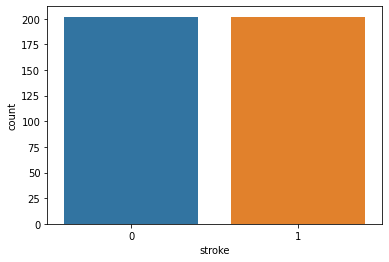

In [328]:
plot_stroke_count(y_us)

Though undersampling helps in reducing the disparity between majority and minority classes, it often leads to the loss of critical data.

# Random Over-sampling

In [329]:
data_ros = pd.concat([data_rfe, y], axis =1)
i=0
while i <=3:
    temp = data_ros.query('stroke ==1')
    data_ros = pd.concat( [data_ros,data_ros.query('stroke ==1')], axis=0)
    i+=1
    
X_ros = data_ros.drop(['stroke'], axis =1)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')
Number of people without stroke attack -  4552
Number of people with stroke attack -  3232


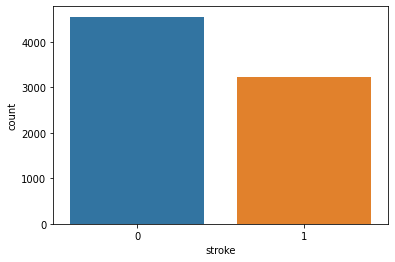

In [330]:
print(data_ros.columns)
plot_stroke_count(data_ros.stroke)

Accuracy is:  0.9828767123287672


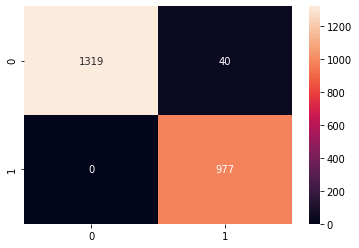

In [331]:
y_test_ros,y_pred_ros = kBest_model(X_ros, data_ros.stroke, 5)

As a result of over-sampling, prominent number of cases in both minority and majority classes are predicted correctly. 

In [332]:
print(classification_report(y_test_ros,y_pred_ros))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1359
           1       0.96      1.00      0.98       977

    accuracy                           0.98      2336
   macro avg       0.98      0.99      0.98      2336
weighted avg       0.98      0.98      0.98      2336



Both precision and recal reveals promising values. However, over-sampling often leads to **over-fitting** of data, since multiple duplicate values of a particular values is appended to the dataset.

# Synthetic minority oversampling technique (SMOTE)

SMOTE is an over-sampling method that also addressed the issue of overfitting. 
Firstly, take the difference between a feature vector (minority class sample) and one of its k nearest neighbors (minority class samples).Then, multiply this difference by a random number between 0 and 1. Finally, add this difference to the feature value of the original feature vector, thus a new feature vector is created

Before applying SMOTE, lets analyze the data.

# Data Pre-Processing

# Analyzing variables

<AxesSubplot:xlabel='avg_glucose_level', ylabel='value'>

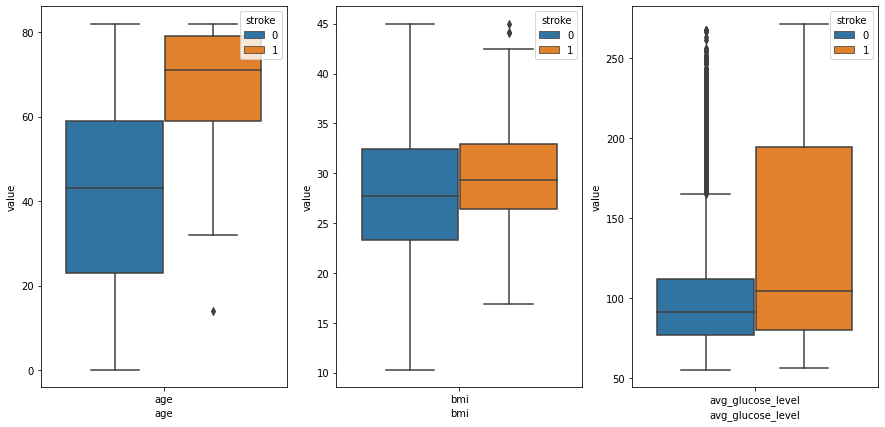

In [333]:
#Understanding continuous variables using a box plot

f, axes = plt.subplots(1,3, figsize=(15,7))

data_age = pd.concat([data.stroke, data.age], axis=1)
data_plot_age = pd.melt(data_age, id_vars = 'stroke', var_name = 'age')
sns.boxplot(x='age', y='value', hue='stroke', data=data_plot_age,ax=axes[0])

data_bmi = pd.concat([data.stroke, data.bmi], axis=1)
data_plot_bmi = pd.melt(data_bmi, id_vars = 'stroke', var_name = 'bmi')
sns.boxplot(x='bmi', y='value', hue='stroke', data=data_plot_bmi,ax=axes[1])

data_agl = pd.concat([data.stroke, data.avg_glucose_level], axis=1)
data_plot_agl = pd.melt(data_agl, id_vars = 'stroke', var_name = 'avg_glucose_level')
sns.boxplot(x='avg_glucose_level', y='value', hue='stroke', data=data_plot_agl,ax=axes[2])

From the plot above, we see that, there is a clear distinction in age, indicating that old people are more prone to stroke. 



In [334]:
# removing outliers for age
data = data.query('(age>25 & stroke ==1) or stroke==0' )

Interestingly, the box plot of avg_glucose_level displays multiple datapoints as outliers, mandating the need for further analysis

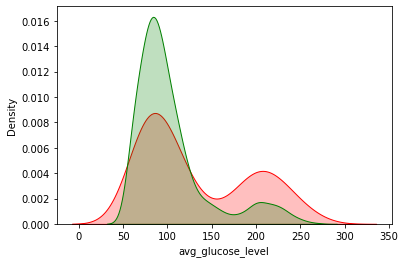

In [335]:
#Analysing avg_glucose_level attribute

stroke1 =data_agl[data_agl['stroke']==1]
stroke0 =data_agl[data_agl['stroke']==0]

sns.kdeplot(stroke1['avg_glucose_level'], shade=True, color="r")
sns.kdeplot(stroke0['avg_glucose_level'], shade=True, color="g")

plt.show()

Green and red denotes those without stroke and with stroke respectively.

Thus, the anomaly observed in box plot is justified by the bimodal distribution of data. 

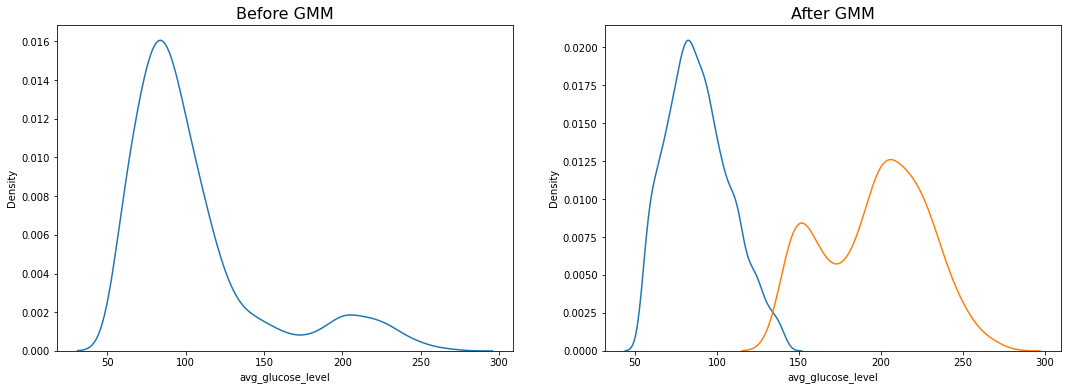

In [336]:
# Using Gausian Mixture Model(GMM)

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data_agl['avg_glucose_level'].values.reshape(-1, 1))
data_agl['gmm']= gmm.predict(data_agl['avg_glucose_level'].values.reshape(-1, 1))

#Visualization
f, ax = plt.subplots(1,2, figsize=(18, 6))
sns.kdeplot(data=data_agl['avg_glucose_level'], ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=data_agl[data_agl['gmm']==0].avg_glucose_level, label='Component 1', ax=ax[1])
sns.kdeplot(data=data_agl[data_agl['gmm']==1].avg_glucose_level, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

# Adding gmm to the input dataset
data['gmm'] = data_agl['gmm']


GMM model helps in identifying and splitting the subpopulations in a normally distributed data. In this case, we are taking datapoints with low average_glucose_level as 0 and the higher value as 1. Since, the healthy population has agl < 140, it understandable that maximum datapoints fall in 0.

<AxesSubplot:xlabel='smoking_status', ylabel='0'>

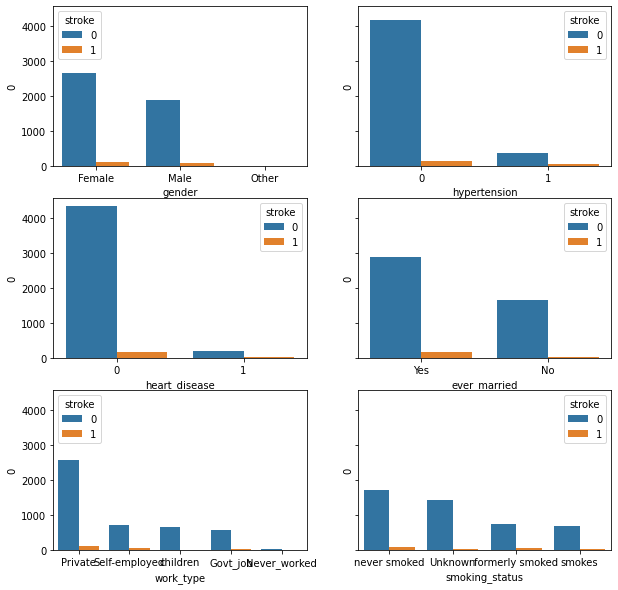

In [337]:
# Using bar plot to understand categorical variables

f, axes = plt.subplots(3, 2, sharey = True, figsize =(10,10))
data_cat = pd.concat([y, x_cat], axis=1)
                          
#gender
data_g = data[['stroke','gender']].value_counts().reset_index()
sns.barplot(x="gender", y=0, hue="stroke", data=data_g, ax=axes[0, 0])
       
#hypertension
data_h = data[['stroke','hypertension']].value_counts().reset_index()
sns.barplot(x="hypertension", y=0, hue="stroke", data=data_h,ax=axes[0, 1])
                          
#heart_disease
data_hd = data[['stroke','heart_disease']].value_counts().reset_index()
sns.barplot(x="heart_disease", y=0, hue="stroke", data=data_hd, ax=axes[1, 0])

#ever_married
data_em = data[['stroke','ever_married']].value_counts().reset_index()
sns.barplot(x="ever_married", y=0, hue="stroke", data=data_em, ax=axes[1, 1])
       
#work_type
data_wt = data[['stroke','work_type']].value_counts().reset_index()
sns.barplot(x="work_type", y=0, hue="stroke", data=data_wt,ax=axes[2, 0])
                          
#smoking_status
data_ss = data[['stroke','smoking_status']].value_counts().reset_index()
sns.barplot(x="smoking_status", y=0, hue="stroke", data=data_ss, ax=axes[2, 1])

In [338]:
y = data.stroke
x_pp = data.drop(['stroke'], axis=1)

In [339]:
#Encoding categarical variables
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
x_pp['gender'] = labelEncoder.fit_transform(x_pp['gender'])
x_pp["ever_married"] = labelEncoder.fit_transform(x_pp['ever_married'])
x_pp['work_type'] = labelEncoder.fit_transform(x_pp['work_type'])
x_pp['Residence_type'] = labelEncoder.fit_transform(x_pp['Residence_type'])
x_pp['smoking_status'] = labelEncoder.fit_transform(x_pp['smoking_status'])
x_pp['heart_disease'] = labelEncoder.fit_transform(x_pp['heart_disease'])

# Collinearity

In [340]:
#x_pp = pd.concat([x_cont, x_cat], axis=1)


#Dropping avg_glucose_level, since gmm attribute gives a better understanding of avg_glucose_level
x_pp = x_pp.drop(['avg_glucose_level'], axis=1)

x_pp.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,gmm
count,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000
mean,0.415948,42.812144,0.088996,0.050705,0.648433,2.179466,0.508100,28.145024,1.370503,0.146223
std,0.493363,22.778143,0.284769,0.219417,0.477510,1.098851,0.499987,6.651194,1.069211,0.353367
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,10.300000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,2.000000,0.000000,23.400000,0.000000,0.000000
50%,0.000000,44.000000,0.000000,0.000000,1.000000,2.000000,1.000000,27.800000,2.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,3.000000,1.000000,32.500000,2.000000,0.000000
max,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,45.000000,3.000000,1.000000


<AxesSubplot:>

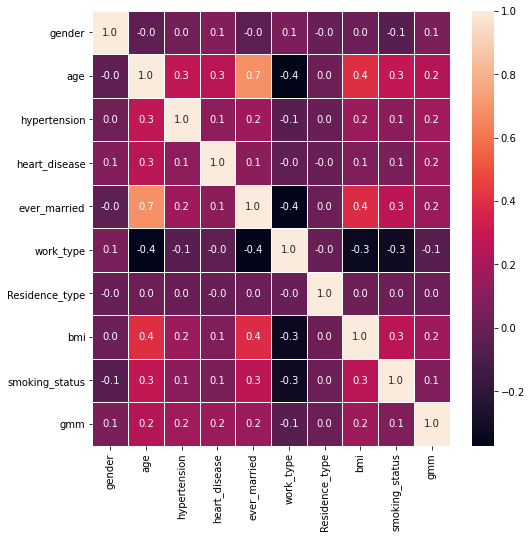

In [341]:
#checking collinearity using heatmap
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(x_pp.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

We see that age and marriage status are correlated, since, legally only those above age 18 can marry.

In [342]:
x_pp = x_pp.drop(['ever_married'], axis =1)

Performing SMOTE sampling

In [343]:
import smote_variants as sv

In [350]:
len(y_sm)

4753

2021-06-30 19:44:40,787:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2021-06-30 19:44:40,789:INFO:MulticlassOversampling: Sampling minority class with label: 1
2021-06-30 19:44:40,790:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Number of people without stroke attack -  4552
Number of people with stroke attack -  4552


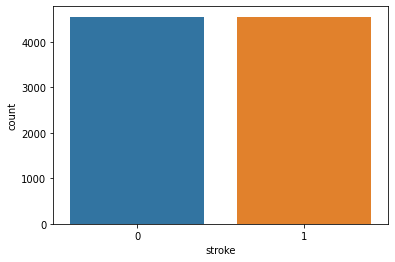

In [351]:
X_smote, y_smote= x_pp.values, y.values
oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_samp, y_samp= oversampler.sample(X_smote, y_smote)
X_df_smote = pd.DataFrame(X_samp, columns = x_pp.columns)
y_sm = pd.Series(y_samp)
y_sm = y_sm.rename('stroke')
plot_stroke_count(y_sm)

Using SMOTE, we have equal levels of majority and minority classes.

# Random Forest Classification with Cross Validation

In [352]:
from sklearn.feature_selection import RFECV

In [353]:
def rfecv_model(x_pp, y):
    x_train, x_test, y_train, y_test = train_test_split(x_pp, y, 
                                                        test_size=0.3, random_state=42)
    clf_rfecv = RandomForestClassifier() 
    rfecv = RFECV(estimator=clf_rfecv, step=1, cv=5,scoring='accuracy') 
    rfecv = rfecv.fit(x_train, y_train)

    print('Optimal number of features :', rfecv.n_features_)
    print('Best features :', x_train.columns[rfecv.support_])

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score of number of selected features")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    x_train_rfecv = rfecv.transform(x_train)
    x_test_rfecv = rfecv.transform(x_test)

    rfecv_1 = rfecv.fit(x_train_rfecv,y_train)
    y_pred_rfecv = rfecv_1.predict(x_test_rfecv)
    ac = accuracy_score(y_test,y_pred_rfecv)
    print('Accuracy is: ',ac)
    cm = confusion_matrix(y_test,y_pred_rfecv)
    sns.heatmap(cm,annot=True,fmt="d")
    print(classification_report(y_test, y_pred_rfecv))
    return y_test,y_pred_rfecv

Optimal number of features : 9
Best features : Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'Residence_type', 'bmi', 'smoking_status', 'gmm'],
      dtype='object')


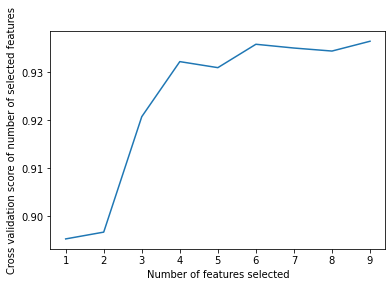

Accuracy is:  0.9344802342606149
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1382
           1       0.92      0.95      0.93      1350

    accuracy                           0.93      2732
   macro avg       0.93      0.93      0.93      2732
weighted avg       0.94      0.93      0.93      2732



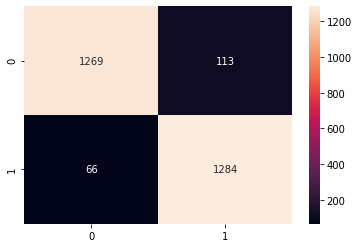

In [354]:
ytest, ypred = rfecv_model(X_train_res, y_train_res)

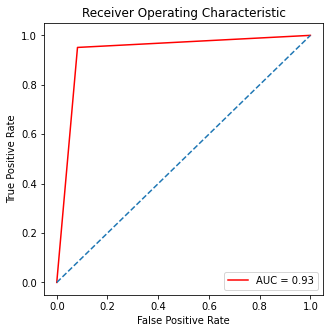

In [355]:
roc_auc_model(ytest, ypred)

AUC score > 0.9 indicates that the model is accurate in prediction of values.

Overall, comparing the accuracy, prediction, recall and AUC score, the model's performance can be categorized as outstanding.

# Conclusion

The model depicts the same dataset yielding better evaluation metrics after sampling than its counterpart. 

Various sampling methods are available and its applications depend on the type and severity of imbalanced dataset. Thus, its always important to analyse the dataset prior to choosing an appropriate sampling method.

Most importantly, accuray of a model **doesnt** indicate a model's excellence. It can only be determined from a consolidated analysis of all evaluation parameters. 